# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import eli5
import shap

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

The problem we are trying to solve is predicting whether or not someone will default on their payment next month. There will be moderate class imbalance (most people will not default), and there are roughly 4 categories of features available for us to analyze and pick apart: 

* Demographic Factores (Sex, Education, Marriage, Age) 
* Repayment Status
* Amount of Bill Statement 
* Amount of Previous Payment

#### Our problem is to classify which customers are likely to default on their debt next month. There is a moderate amount of class imbalance and there may be more importance to predicting one class over another

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv", index_col="ID")
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
X_train = train.drop(columns=["default.payment.next.month"])
y_train = train["default.payment.next.month"]

X_test = test.drop(columns=["default.payment.next.month"])
y_test = test["default.payment.next.month"]

X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,5,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [4]:
# There appear to be no missing values, however all of the "categorical" variables have been encoded as numbers and will need to be examined. 
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21754 to 23655
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_0      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PA

In [5]:
# Summary statistics for all the variables. 
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,167226.653333,1.604917,1.854000,1.551417,35.494375,-0.016667,-0.131375,-0.168167,-0.220417,-0.265167,...,4.675708e+04,43013.532167,40150.333000,38763.540458,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125
std,129734.959196,0.488879,0.792176,0.522766,9.235160,1.126473,1.197675,1.191685,1.168107,1.132949,...,6.926506e+04,64069.494705,60635.882129,59281.986863,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.699500e+03,2329.000000,1763.000000,1271.750000,1000.000000,8.615000e+02,390.000000,285.750000,240.750000,112.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.005000e+04,19010.000000,18085.000000,17108.500000,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.952925e+04,53927.750000,50007.500000,49101.750000,5005.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000


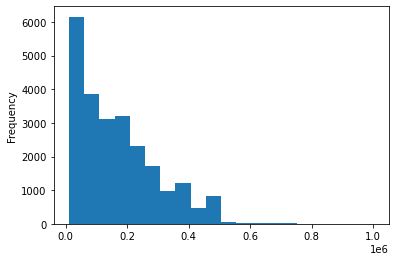

In [6]:
ax = X_train["LIMIT_BAL"].plot.hist(bins=20, xlabel="Amount of Credit Given, Millions of New Taiwan Dollars")

#### This histogram shows that the amount of available credit is very right-skewed - this may be important later when thinking about how different levels of credit may default/not. 

In [7]:
nfeats = train.drop(columns=["SEX", "EDUCATION", "MARRIAGE", "default.payment.next.month"])
corr = nfeats.corr()
corr.style.background_gradient(cmap='coolwarm')

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.149027,-0.268788,-0.297163,-0.285663,-0.268756,-0.248837,-0.235134,0.283519,0.277148,0.281470,0.292581,0.295307,0.290745,0.195353,0.171262,0.209060,0.202258,0.218756,0.223813
AGE,0.149027,1.000000,-0.039049,-0.048026,-0.053835,-0.050055,-0.056765,-0.051623,0.055081,0.054103,0.052662,0.050386,0.048425,0.045598,0.026449,0.020945,0.024485,0.021496,0.020516,0.018364
PAY_0,-0.268788,-0.039049,1.000000,0.674819,0.578488,0.542034,0.510700,0.475909,0.190892,0.193454,0.182359,0.182343,0.183004,0.178879,-0.077084,-0.068846,-0.069413,-0.063703,-0.059661,-0.060536
PAY_2,-0.297163,-0.048026,0.674819,1.000000,0.768607,0.663979,0.623256,0.573964,0.236031,0.236194,0.224340,0.222346,0.221632,0.219033,-0.080737,-0.058338,-0.057261,-0.044199,-0.039196,-0.038902
PAY_3,-0.285663,-0.053835,0.578488,0.768607,1.000000,0.777305,0.687956,0.630131,0.213911,0.242600,0.231889,0.232377,0.229803,0.226695,0.002362,-0.064008,-0.052183,-0.042921,-0.035479,-0.035374
PAY_4,-0.268756,-0.050055,0.542034,0.663979,0.777305,1.000000,0.820118,0.715312,0.205298,0.228236,0.247440,0.249282,0.246097,0.242702,-0.010525,-0.002408,-0.066290,-0.040970,-0.034840,-0.028571
PAY_5,-0.248837,-0.056765,0.510700,0.623256,0.687956,0.820118,1.000000,0.814612,0.207590,0.228249,0.243761,0.273439,0.270517,0.263417,-0.005026,-0.003764,0.010962,-0.058200,-0.033812,-0.023250
PAY_6,-0.235134,-0.051623,0.475909,0.573964,0.630131,0.715312,0.814612,1.000000,0.208090,0.227709,0.241647,0.268082,0.292026,0.286383,-0.001773,-0.003809,0.007072,0.019774,-0.047222,-0.026365
BILL_AMT1,0.283519,0.055081,0.190892,0.236031,0.213911,0.205298,0.207590,0.208090,1.000000,0.951598,0.888002,0.855804,0.827622,0.800231,0.137794,0.093362,0.153194,0.158455,0.160830,0.185262
BILL_AMT2,0.277148,0.054103,0.193454,0.236194,0.242600,0.228236,0.228249,0.227709,0.951598,1.000000,0.925135,0.890216,0.859068,0.830404,0.277192,0.097373,0.151639,0.147812,0.155904,0.181586


#### LIMIT_BAL (Extended credit) and PAY_X have a high negative correlation - this makes sense, as only people who pay on time get extended more credit. 

#### Since we have imbalanced classes and since both false positives and false positives have a cost to the bank, which I can assume is roughly equal (LTV of not enough credit ≃ physical collateral collected on a bad debt), I believe that F-1 is our best choice for a evaluating our models

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [8]:
numeric_feats = [
    "LIMIT_BAL",
    "AGE",
    "PAY_0", 
    "PAY_2", 
    "PAY_3", 
    "PAY_4", 
    "PAY_5",
    "PAY_6", 
    "BILL_AMT1", 
    "BILL_AMT2", 
    "BILL_AMT3", 
    "BILL_AMT4", 
    "BILL_AMT5", 
    "BILL_AMT6", 
    "PAY_AMT1", 
    "PAY_AMT2", 
    "PAY_AMT3" , 
    "PAY_AMT4", 
    "PAY_AMT5", 
    "PAY_AMT6"
    
]  # apply scaling 
passthrough_feats = ["SEX", "MARRIAGE", "EDUCATION"] # Categorical features are already encoded

ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features 
    ("passthrough", passthrough_feats) # passthrough other feautures. 
)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
                                  'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6']),
                                ('passthrough', 'passthrough',
                                 ['SEX', 'MARRIAGE', 'EDUCATION'])])

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [9]:
dc = DummyClassifier() 
dc.fit(X_train, y_train)
dc.score(X_train, y_train) 

0.7782083333333333

#### This isn't what we're interested in. Let's calculate F-1 instead to get a baseline to compare our models against. 

In [10]:
y_pred = dc.predict(X_train)

f1_score(y_train, y_pred)

0.0

#### What happened?! Our F1-score is 0 because the dummy classifier never identifies a positive value (predicting a customer will default next month) because it is the less common class. We'll have to start looking at F-1 when using more robust classifiers (logreg, svm rbfs, ensembles, etc)

In [11]:
### Define function to display std and cv scores for use in part 7 and 8. Used from lecture 5. 
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [12]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

log_results = {}

for c in param_grid["C"]: 
    pipe_lr = make_pipeline(ct, LogisticRegression(C=c))
    log_results["C=" + str(c)] = mean_std_cross_val_scores(
        pipe_lr, X_train, y_train, return_train_score=True, scoring="f1"
    )
    
pd.DataFrame(log_results).T

,fit_time,score_time,test_score,train_score
C=0.001,0.058 (+/- 0.011),0.006 (+/- 0.001),0.272 (+/- 0.010),0.273 (+/- 0.007)
C=0.01,0.078 (+/- 0.015),0.008 (+/- 0.001),0.345 (+/- 0.015),0.349 (+/- 0.008)
C=0.1,0.098 (+/- 0.008),0.008 (+/- 0.002),0.359 (+/- 0.016),0.362 (+/- 0.007)
C=1,0.107 (+/- 0.012),0.008 (+/- 0.001),0.361 (+/- 0.017),0.364 (+/- 0.007)
C=10,0.114 (+/- 0.014),0.007 (+/- 0.002),0.361 (+/- 0.017),0.364 (+/- 0.007)
C=100,0.105 (+/- 0.013),0.006 (+/- 0.001),0.361 (+/- 0.017),0.364 (+/- 0.007)


#### We are able to increase our F1 score from 0 to a mean CV score of approximately 0.36 by using a logistic regression model with C = 1.0. Any increases of C beyond this point do not improve the F1 score. 

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [13]:
results = {}

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))

pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(ct, CatBoostClassifier(verbose=0, random_state=123))

classifiers = {
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="f1"
    )


<br><br>

In [14]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
decision tree,0.349 (+/- 0.026),0.010 (+/- 0.005),0.403 (+/- 0.013),0.999 (+/- 0.000)
random forest,4.049 (+/- 0.081),0.111 (+/- 0.012),0.472 (+/- 0.012),0.999 (+/- 0.000)
LightGBM,0.263 (+/- 0.024),0.022 (+/- 0.002),0.476 (+/- 0.009),0.565 (+/- 0.003)
CatBoost,8.014 (+/- 0.760),0.009 (+/- 0.006),0.475 (+/- 0.008),0.594 (+/- 0.003)


#### All four of the models tested are able to produce a higher cross_validation score using f1 as the metric than logistic regression. In the next steps, I would be most likely to use LightGBM because it has the highest CV score, the 2nd lowest standard deviation, and it's fit and score times are comparitively very fast to the other ensemble models. 

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [15]:
pipe_forward = make_pipeline(
    ct, 
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="forward"
    ),
    LGBMClassifier(random_state=123)
)
pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True, scoring="f1")).mean()

fit_time       25.197477
score_time      0.028044
test_score      0.455606
train_score     0.525424
dtype: float64

#### There is no improvement of the mean cross validation score with forward selection. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [16]:
parameters = {
    'lgbmclassifier__num_leaves': [5, 10, 20, 30, 40, 50],
    'lgbmclassifier__max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'lgbmclassifier__boosting_type' : ['gbdt','goss', 'dart']
    }

pipe_grid = make_pipeline(
    ct, 
    LGBMClassifier(random_state=123)
)

grid_clf = GridSearchCV(pipe_grid, parameters, n_jobs=-1, cv=5, scoring='f1')
grid_clf.fit(X=X_train, y=y_train)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

{'lgbmclassifier__boosting_type': 'goss', 'lgbmclassifier__max_depth': 9, 'lgbmclassifier__num_leaves': 20}
0.4828469131813161


#### After testing on the listed parameters, and after also looking at the RadomizedSearch, I was able to squeeze out a little bit more performance by setting the boosting type to goss, max_depth to 9 and num_leaves to 20. 

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [17]:
feature_names = numeric_feats + passthrough_feats


pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123, num_leaves=20, max_depth=4, boosting_type='goss'))
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3541,PAY_0
0.0604,LIMIT_BAL
0.0604,PAY_AMT2
0.0485,PAY_AMT3
0.0479,PAY_AMT1
0.0475,BILL_AMT1
0.0391,PAY_AMT6
0.0377,PAY_2
0.0333,PAY_AMT5
0.0327,PAY_AMT4


#### By a very large margin, the most important feature in determining whether or not a client will pay back is PAY-0, which represents their payment_delay (if it exists) in months by September 2005, the most recent month to when this data was collected. Intuitively this makes sense - clients that have paid duly or are barely behind are very likely to not default, and debtors who are behind are much more likely to default. 

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [18]:
grid_clf.score(X_test, y_test)

0.46183762761302866

#### The test score seems to agree with the validation score from before, witch a discrepancy of just about 0.02. I think that these results are reasonable, but may be hard to "intuit" because of using the f1-score, and the small size of the training set. It's possible that I've had issues with optimization bias because we've compared many different decision trees as part of the ensemble with a max depth less than 10, which has increased the variation in the model select stage and has increased the likelihood that we've overfitted the model and that the one we've chosen is just lucky. 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


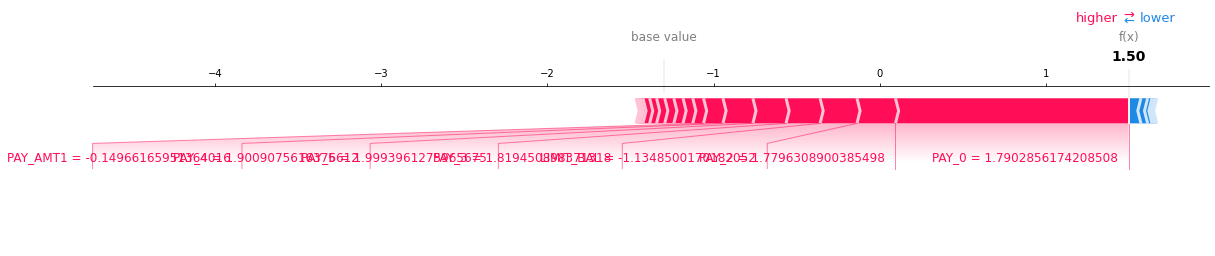

In [19]:
X_train_enc = pd.DataFrame(
    data=ct.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

X_test_enc = pd.DataFrame(
    data=ct.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

y_test_reset = y_test.reset_index(drop=True)
y_test_reset

default_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_default = default_ind[5]

pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_default]

shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_default, :],
    X_test_enc.iloc[ex_default, :],
    matplotlib=True,
)


#### Intuitively this makes sense - this debtor was nearly 1.8 standard deviations over the mean value for PAY_0, meaning he was likely very behind on his payments when they were surveyed. 

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

#### 1. The final F1 score is 0.465 

#### 2. This has been a useful exercise in creating a model to determine the creditworthiness of the borrowers, as well as look at comparing different models to each other. My final model improved the F1 score, whic his the harmonic mean of precision and recall from the LogisticRegression "baseline" (since the DummyClassifier doesn't have a well-formed F1 score) by over 0.1. 

#### 3. I wish I had more time to figure out whether the subsequent improvements were from improving precision or recall. Additionally, I wish I could more deeply examine hyperparameters for more than 1 type of model to see if any of them could have yielded a better improvement in the CV score. Lastly, I may have introduced some bias in the ordering by leaving the categorical features as passthrough variables instead of explicitly creating new columns, but I doubt the change would be very large based on the small number of categories and ordinal nature of 'education'. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 